## Is it possible to predict how betting odds will change, by using predicted polling data?

In [70]:
import requests
import numpy as np
import pandas as pd
from realclearpolling import *

In [71]:
url = 'https://www.realclearpolitics.com/json/odds/event_106_final.json?'
response = requests.get(url)
data = response.json()
print(data)

{'poll': {'rcp_avg': [{'date_r': 'Wed, 13 Mar 2024 00:00:00 -0400', 'candidates': [{'id': '2081', 'name': 'Donald Trump', 'color': '#d30015', 'value': '45.5'}, {'id': '2090', 'name': 'Joe Biden', 'color': '#0a0ab2', 'value': '33.7'}, {'id': '2244', 'name': 'Michelle Obama', 'color': '#c3c3de', 'value': '5.8'}, {'id': '2094', 'name': 'Gavin Newsom', 'color': '#7381C9', 'value': '4.5'}, {'id': '2473', 'name': 'Robert Kennedy Jr', 'color': '#993300', 'value': '3.7'}, {'id': '2092', 'name': 'Kamala Harris', 'color': '#00e4ff', 'value': '3.0'}, {'id': '2086', 'name': 'Nikki Haley', 'color': '#bf40b0', 'value': '2.0'}, {'id': '2564', 'name': 'Dean Phillips', 'color': '#37aac7', 'value': '0.5'}, {'id': '2451', 'name': 'Vivek Ramaswamy', 'color': '#3da882', 'value': '0.5'}]}, {'date_r': 'Tue, 12 Mar 2024 00:00:00 -0400', 'candidates': [{'id': '2081', 'name': 'Donald Trump', 'color': '#d30015', 'value': '45.2'}, {'id': '2090', 'name': 'Joe Biden', 'color': '#0a0ab2', 'value': '32.6'}, {'id': '2

In [72]:
def get_candidate_odds(data, candidate):
    nlist = []
    for i in range(len(data)):
        values = data[i]['candidates']
        for value in values:
            if value['name'] == candidate:
                nlist.append(value['value'])
    return nlist 

def get_dates(data):
    nlist = []
    for i in range(len(data)):
        nlist.append(data[i]['date_r'])
    return nlist

dates = get_dates(data['poll']['rcp_avg'])
trump_odds = get_candidate_odds(data['poll']['rcp_avg'], 'Donald Trump')
biden_odds = get_candidate_odds(data['poll']['rcp_avg'], 'Joe Biden')

In [73]:
# Make a dataframe with dates, Trump odds, Biden odds
df = pd.DataFrame({'date': dates, 'trump': trump_odds, 'biden': biden_odds})
df['date'] = pd.to_datetime(df['date'],utc=True)
df['date'] = df['date'].dt.date
df['biden_rolling'] = df['biden'].rolling(window=1).mean()
df['trump_rolling'] = df['trump'].rolling(window=1).mean()
df.sort_values(by='date', inplace=True)
df

,date,trump,biden,biden_rolling,trump_rolling
432,2023-01-03,14.3,27.7,27.7,14.3
431,2023-01-04,14.6,28.0,28.0,14.6
430,2023-01-05,15.2,28.0,28.0,15.2
429,2023-01-06,14.8,28.0,28.0,14.8
428,2023-01-09,15.2,27.4,27.4,15.2
...,...,...,...,...,...
4,2024-03-09,45.7,32.3,32.3,45.7
3,2024-03-10,45.4,32.6,32.6,45.4
2,2024-03-11,45.4,32.6,32.6,45.4
1,2024-03-12,45.2,32.6,32.6,45.2


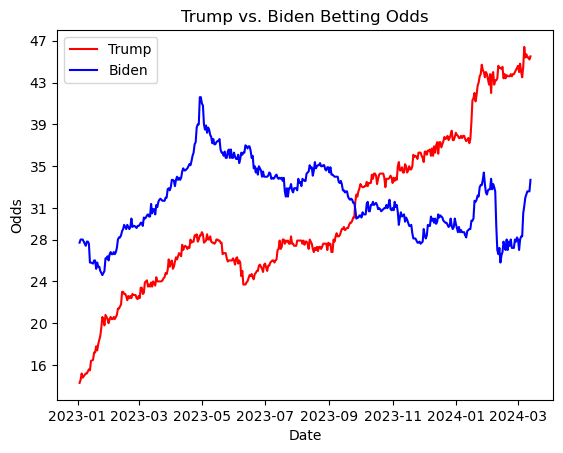

In [74]:
# Plot the odds as a time series
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots()

# Use AutoDateLocator to set a reasonable date format
ax.yaxis.set_major_locator(mdates.AutoDateLocator())
plt.plot(df['date'], np.array(df['trump_rolling']), label='Trump',color = 'red')
plt.plot(df['date'], np.array(df['biden_rolling']), label='Biden', color = 'blue')
ax.set_xlabel('Date')
ax.set_ylabel('Odds')
ax.set_title('Trump vs. Biden Betting Odds')
ax.legend()
plt.show()

In [75]:
rcp = clean_data(get_poll_data())
rcp.head()

,pollster,date,sample,moe,Trump (R),Biden (D),spread,Difference,Type of Voter,Sample Size,End Date,Poll Month,Year,Days Since 01-01-23
0,Economist/YouGov,3/10 - 3/12,1367 RV,3.5,44.0,42.0,Trump+2,2.0,RV,1367,2024-03-12,3,2024,436
2,Forbes/HarrisX,3/8 - 3/10,2017 RV,2.2,52.0,48.0,Trump+4,4.0,RV,2017,2024-03-10,3,2024,434
3,Morning Consult,3/8 - 3/10,6300 RV,1.0,44.0,43.0,Trump+1,1.0,RV,6300,2024-03-10,3,2024,434
4,Rasmussen Reports,3/5 - 3/7,912 LV,3.0,49.0,41.0,Trump+8,8.0,LV,912,2024-03-07,3,2024,431
5,Emerson,3/5 - 3/6,1350 RV,2.6,49.0,51.0,Biden+2,-2.0,RV,1350,2024-03-06,3,2024,430


In [76]:
# Plot polling data on a time series

#Is it possible to subset the predictions to only include the unique dates?
dates = rcp["End Date"]
unique_dates = np.unique(dates)

biden_vals = []
trump_vals = []

for date in unique_dates:
    mask = rcp["End Date"] == date
    biden_vals.append(rcp[mask]["Biden (D)"].mean())
    trump_vals.append(rcp[mask]["Trump (R)"].mean())

ndf = pd.DataFrame({'date': unique_dates, 'trump': trump_vals, 'biden': biden_vals})
ndf["Biden Rolling"] = ndf["biden"].rolling(window=5).mean()
ndf["Trump Rolling"] = ndf["trump"].rolling(window=5).mean()
ndf.sort_values(by='date', inplace=True)
ndf.head()



,date,trump,biden,Biden Rolling,Trump Rolling
0,2023-01-16,40.0,46.0,NaN,NaN
1,2023-01-17,42.0,46.0,NaN,NaN
2,2023-01-19,46.0,41.0,NaN,NaN
3,2023-01-20,43.0,40.0,NaN,NaN
4,2023-01-21,44.0,41.0,42.8,43.0


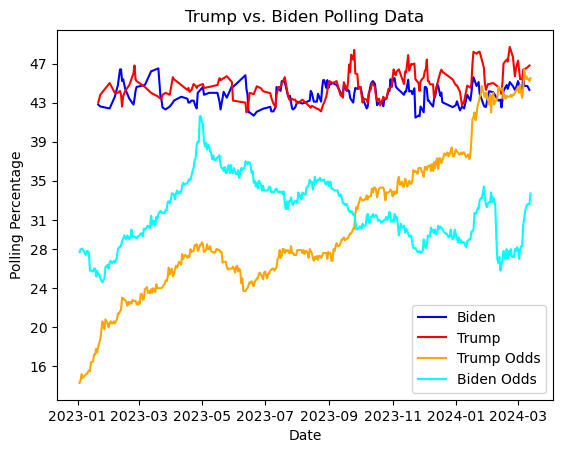

In [77]:
fig, ax = plt.subplots()
ax.yaxis.set_major_locator(mdates.AutoDateLocator())
plt.plot(unique_dates, ndf['Biden Rolling'], label='Biden',color = 'blue')
plt.plot(unique_dates, ndf['Trump Rolling'], label='Trump', color = 'red')
plt.plot(df['date'], np.array(df['trump_rolling']), label='Trump Odds',color = 'orange')
plt.plot(df['date'], np.array(df['biden_rolling']), label='Biden Odds', color = 'aqua')
ax.set_xlabel('Date')
ax.set_ylabel('Polling Percentage')
ax.set_title('Trump vs. Biden Polling Data')
ax.legend()
plt.show()

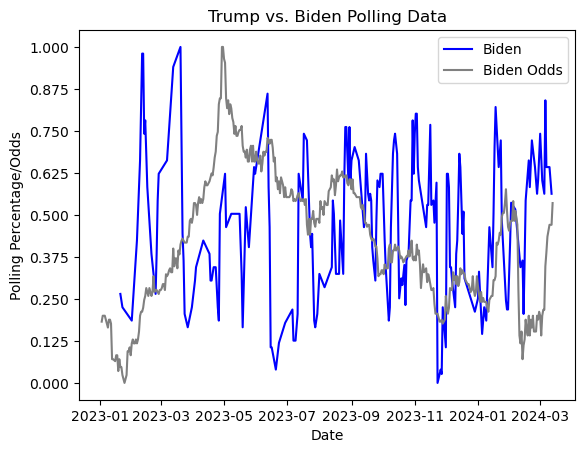

In [78]:
# We should try to rescale the data to be between 0 and 1

# We can use the min-max scaling method to rescale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
ndf['Biden Rolling'] = scaler.fit_transform(ndf['Biden Rolling'].values.reshape(-1,1))
ndf['Trump Rolling'] = scaler.fit_transform(ndf['Trump Rolling'].values.reshape(-1,1))
df['biden_rolling'] = scaler.fit_transform(df['biden_rolling'].values.reshape(-1,1))
df['trump_rolling'] = scaler.fit_transform(df['trump_rolling'].values.reshape(-1,1))

fig, ax = plt.subplots()
ax.yaxis.set_major_locator(mdates.AutoDateLocator())
plt.plot(unique_dates, ndf['Biden Rolling'], label='Biden',color = 'blue')
#plt.plot(unique_dates, ndf['Trump Rolling'], label='Trump', color = 'red')
#plt.plot(df['date'], np.array(df['trump_rolling']), label='Trump Odds',color = 'orange')
plt.plot(df['date'], np.array(df['biden_rolling']), label='Biden Odds', color = 'grey')
ax.set_xlabel('Date')
ax.set_ylabel('Polling Percentage/Odds')
ax.set_title('Trump vs. Biden Polling Data')
ax.legend()
plt.show()

## General Observations

It looks like the odds precurse the polls. This makes sense, since odds are based on real time news updates, and polls face lag effects. 

In [79]:
#Let's just try to make a linear regression model that takes day + betting odds and predicts polling data

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error



In [80]:
df["Date"] = pd.to_datetime(df["date"])
ndf["Date"] = pd.to_datetime(ndf["date"])
merged = pd.merge(df, ndf, on="Date", how="inner")
merged["Days Since Start"] = (merged["Date"] - merged["Date"].min()).dt.days
merged.head()

,date_x,trump_x,biden_x,biden_rolling,trump_rolling,Date,date_y,trump_y,biden_y,Biden Rolling,Trump Rolling,Days Since Start
0,2023-01-16,16.5,25.7,0.064706,0.068536,2023-01-16,2023-01-16,40.0,46.0,NaN,NaN,0
1,2023-01-17,17.2,26.0,0.082353,0.090343,2023-01-17,2023-01-17,42.0,46.0,NaN,NaN,1
2,2023-01-19,17.8,25.2,0.035294,0.109034,2023-01-19,2023-01-19,46.0,41.0,NaN,NaN,3
3,2023-01-20,17.4,25.8,0.070588,0.096573,2023-01-20,2023-01-20,43.0,40.0,NaN,NaN,4
4,2023-01-21,18.0,25.4,0.047059,0.115265,2023-01-21,2023-01-21,44.0,41.0,0.264901,0.149254,5


In [81]:
training_df = merged[["Days Since Start", "biden_x"]]
training_df["biden_x"] =  training_df["biden_x"].astype(float).copy()
X = training_df.dropna()
y = merged["biden_x"]
y.dropna(inplace=True)
X["SinFreq1"] = np.sin(2 * np.pi * X["Days Since Start"] / 365)
X["CosFreq1"] = np.cos(2 * np.pi * X["Days Since Start"] / 365)
X.head()


/var/folders/h7/ctfkf21x7jd7ykb9j1km5blr0000gp/T/ipykernel_6777/2641727642.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_df["biden_x"] =  training_df["biden_x"].astype(float).copy()


,Days Since Start,biden_x,SinFreq1,CosFreq1
0,0,25.7,0.000000,1.000000
1,1,26.0,0.017213,0.999852
2,3,25.2,0.051620,0.998667
3,4,25.8,0.068802,0.997630
4,5,25.4,0.085965,0.996298


In [82]:
#Train the linear regression model
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

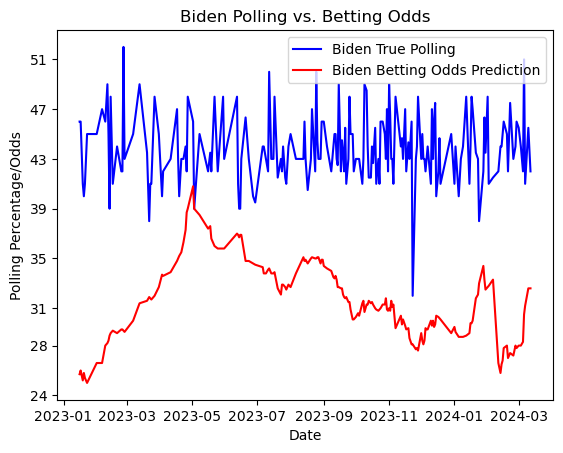

In [83]:
#Plot the results
fig, ax = plt.subplots()
ax.yaxis.set_major_locator(mdates.AutoDateLocator())
plt.plot(merged["Date"], merged["biden_y"], label='Biden True Polling',color = 'blue')
plt.plot(merged["Date"], y_pred, label='Biden Betting Odds Prediction', color = 'red')
ax.set_xlabel('Date')
ax.set_ylabel('Polling Percentage/Odds')
ax.set_title('Biden Polling vs. Betting Odds')
ax.legend()
plt.show()


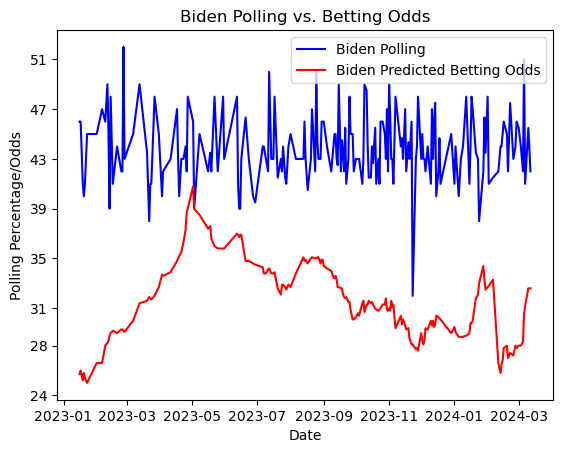

In [84]:
#Try XGBoost instead
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

model = XGBRegressor()
model.fit(X, y)
y_pred = model.predict(X)

#Plot the results
fig, ax = plt.subplots()
ax.yaxis.set_major_locator(mdates.AutoDateLocator())
plt.plot(merged["Date"], merged["biden_y"], label='Biden Polling',color = 'blue')
plt.plot(merged["Date"], y_pred, label='Biden Predicted Betting Odds', color = 'red')
#plt.plot(merged["Date"], merged["biden_x"], label='Actual Biden Betting Odds', color = 'green')
ax.set_xlabel('Date')
ax.set_ylabel('Polling Percentage/Odds')
ax.set_title('Biden Polling vs. Betting Odds')
ax.legend()
plt.show()


In [85]:
#Make a new prediction df
X

,Days Since Start,biden_x,SinFreq1,CosFreq1
0,0,25.7,0.000000,1.000000
1,1,26.0,0.017213,0.999852
2,3,25.2,0.051620,0.998667
3,4,25.8,0.068802,0.997630
4,5,25.4,0.085965,0.996298
...,...,...,...,...
196,414,28.3,0.746972,0.664855
197,415,30.5,0.758306,0.651899
198,416,31.2,0.769415,0.638749
199,419,32.6,0.801361,0.598181


In [86]:
#Let's train a model that uses betting odds today to predict polling data tomorrow

## I know a poll is getting released tomorrow. What data do I have right now to predict what that poll is going to say?
- All prior polls that have been released.
- Betting data up to now. 
- How do we assign a date to the polling data? - Assign the date to be the day afterwards. 
- Use betting data, from the last date of the poll. I.e. if the poll ends up on March 12th, then we should be using betting data from march 12th only. 